In [155]:
import re
from bs4 import BeautifulSoup
import pickle
import pandas as pd
import operator
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
% matplotlib inline

In [127]:
def store_pickles(filename, to_store):
    """Dumps information in to_store into a file named filename.
    
    filename = string
    to_store = list, dictionary, etc.    
    """  
    with open(filename, 'w') as f:
        pickle.dump(to_store, f)
        
        
def eat_pickles(filename):
    """Loads information from a pickle file.
    
    filename = string
    """
    
    with open(filename, 'r') as f:
        return pickle.load(f)

In [43]:
def build_soup_page(page = "", url = "", use_url=False):
    """
    builds a beautifulsoup object from a url if a url is passed, otherwise just creates a BeautifulSoup object
    """
    if use_url:
        page = urllib2.urlopen(url)
        soup = BeautifulSoup(page, 'xml')
    else:
        soup = BeautifulSoup(page)
    return soup

### Wine.com

In [25]:
wines = eat_pickles('wine_com_dict.pkl')

In [26]:
wine_df = pd.DataFrame(wines)

In [33]:
len(wine_df)

7462

In [35]:
wine_df.head(25)

,acclaim,name,notes,region,reviews,varietal
0,"[""The 2012 Pinot Noir Russian River Valley imp...",La Crema Russian River Pinot Noir 2012,The 2012 Russian River Valley Pinot Noir opens...,"Russian River, California",[],Pinot Noir
1,"[""Dark ruby. Cherry and dark berries on the n...",Artazu Artazuri Garnacha 2012,A consumer-friendly wine that boasts heady aro...,Spain,[Nice berry on the nose but the promise of a f...,Grenache
2,"[""Lots of oak and lees on this Chardonnay, but...",Dutton Estate Kyndall's Reserve Chardonnay 2012,Kyndall's Reserve Chardonnay is a delightful t...,"Russian River, California",[],Chardonnay
3,"[""Suave and mineral, this wine is blended from...",Chapter 24 Fire + Flood The Fire Pinot Noir 2012,The Fire is all vibrancy and spark which Chapt...,"Willamette Valley, Oregon",[],Pinot Noir
4,N/A,Ghost Pines Chardonnay 2013,Ghost Pines Chardonnay represents the rich win...,California,[],Chardonnay
5,N/A,Sonoma-Cutrer Sonoma Coast Chardonnay 2013,"Fruit aromas of Golden Delicious apple, Bosc p...","Sonoma County, California",[],Chardonnay
6,N/A,Joel Gott Sauvignon Blanc 2013,The 2013 Joel Gott California Sauvignon Blanc ...,California,[Love this wine! Smells like tropical fruits a...,Sauvignon Blanc
7,N/A,Folie a Deux Russian River Chardonnay 2013,"Seductive, complex aromas of honey, green appl...","Russian River, California",[this is a great value at this price!],Chardonnay
8,"[""The 2012 Roberta’s Reserve (100% Merlot aged...",Kapcsandy Family Winery State Lane Vineyard Ro...,N/A,"Napa Valley, California",[],Cabernet Sauvignon
9,N/A,Dom. du Pesquier Cotes du Rhone 2011,"Blend: 56% Grenache, 30% Mourvèdre, 14% Carignan","Cotes du Rhone, Rhone, France",[],Rhone Red Blends


#### Locate non-wines and drop them from the dataframe

In [28]:
non_wine = ['Vodka', 'Vermouth', 'Whiskey', 'Rum', 'Sangria', 'Tequila', 'Liqueur', 'Brandy', 'Scotch', \
        'Single Malt Scotch', 'Scotch Single Malt', 'Bourbon', 'Whiskey Rye', 'Burgundy', 'Irish Whiskey', \
        'Cream Liqueur', 'Spirit' 'Gin', 'Cognac; Armagnac', 'Liqueurs', 'Apertif And Bitters', 'Whiskey Bourbon', \
        'Cognac', 'Whisky', 'Accessories']

wine_indices_to_drop = []

for index, winename in enumerate(wine_df['name']):
    for nonwine in non_wine:
        if nonwine in winename:
            wine_indices_to_drop.append(index)

In [29]:
wine_indices_to_drop = list(wine_indices_to_drop)

In [30]:
wine_df = wine_df.drop(wine_df.index[[wine_indices_to_drop]])

In [32]:
# Widdle down to wines, not gifts or packages
wine_df = wine_df[wine_df.varietal != "N/A"]

In [34]:
# Count how many reviews that are empty
count = 0
for review in wine_df.reviews:
    if len(review) == 0:
        count += 1

In [35]:
# Total number of wines that had reviews in entire data set
print len(wine_df) - count

806


In [38]:
tot_reviews = []
for review in wine_df.reviews.values:
    if review:
        for single in review:
            tot_reviews.append(single)

In [39]:
len(tot_reviews)

1850

In [63]:
# Count how many acclaims are empty
count3 = 0
for acclaim in wine_df.acclaim:
    if acclaim == 'N/A':
        count3 += 1

In [64]:
# Total number of wines that had acclaims in entire data set
print len(wine_df) - count3

3439


In [55]:
wine_df.varietal.value_counts()

Pinot Noir                    920
Chardonnay                    772
Cabernet Sauvignon            753
Bordeaux Red Blends           535
Other Red Blends              478
Sauvignon Blanc               366
Syrah/Shiraz                  344
Rhone Red Blends              248
Non-Vintage Sparkling Wine    244
Zinfandel                     207
Sangiovese                    196
Merlot                        182
Pinot Gris/Grigio             167
Rosé                          152
Tempranillo                   151
Riesling                      146
Other White Blends            142
Other White Wine              133
Malbec                        133
Other Red Wine                124
Nebbiolo                      110
Rosé Sparkling Wine            94
Vintage Sparkling Wine         86
Other Dessert                  82
Grenache                       81
Port                           62
Rhone White Blends             44
Barbera                        44
Muscat                         42
Viognier      

### Tasting.com

In [129]:
tasting_wines = eat_pickles('tasting_wines.pkl')

In [176]:
tas_df = pd.DataFrame(tasting_wines)

In [139]:
len(tas_df)

8498

In [182]:
tas_df.head()

,color,name,review,varietal
0,Sparkling,"Codornu NV Original, D.O. Cava $10.","Aromas of peach yogurt, fig cookie and a hint ...",Cava
1,Sparkling,"Anna de Codornu NV Brut, D.O. Cava $14.99. Bes...","Robust aromas of baked apple, peach and banana...",Cava
2,Sparkling,"Anna de Codornu NV Brut Ros, D.O. Cava $14.99....",Steely salmon color. Aromas of strawberry tart...,Cava
3,Sparkling,"Sweet Bitch NV Moscato Ros Bubbly, Italy $12. ...",Pretty silver pink color. Aromas and flavors o...,Sparkling
4,Red,"10SPAN 2012 Pinot Noir, Santa Barbara County $...","Ruby black color. Aromas of lipstick, dried ch...",Pinot Noir


In [138]:
tas_df.color.value_counts()

Red          4471
White        2807
Sparkling     353
Dessert       312
Sake          163
Pink          128
Rosé          102
Fortified      68
Mead           46
Fruit          41
Wine            5
RTD             1
Rose            1
dtype: int64

#### TF-IDF on Tasting Dataset

In [140]:
tas_rev_corpus = list(tas_df['review'][:500].values)

In [150]:
vectorizer = TfidfVectorizer(min_df=1, stop_words=('english'), ngram_range=(1,3))
tas_rev = vectorizer.fit_transform(tas_rev_corpus)
idf = vectorizer.idf_
tas_rev = tas_rev.toarray()

In [151]:
tas_rev.shape

(500, 17260)

In [153]:
for i, sing_rev in enumerate(tas_rev):
    tf_idf = dict([(word, count) for (word, count) in zip(vectorizer.get_feature_names(), sing_rev) if count > 0])
    print
    print 'Top 10 TF-IDF Words for Document: {0}'.format(i+1)
    for common in Counter(tf_idf).most_common(10):
        print common


Top 10 TF-IDF Words for Document: 1
(u'finish charming rustic', 0.17827597435514148)
(u'charming rustic', 0.17827597435514148)
(u'peach yogurt fig', 0.17827597435514148)
(u'hint rubber', 0.17827597435514148)
(u'rustic sipper', 0.17827597435514148)
(u'rubber crisp dryish', 0.17827597435514148)
(u'fig cookie hint', 0.17827597435514148)
(u'yogurt fig', 0.17827597435514148)
(u'yogurt fig cookie', 0.17827597435514148)
(u'cookie hint', 0.17827597435514148)

Top 10 TF-IDF Words for Document: 2
(u'edge highly carbonated', 0.15207776106784723)
(u'peach banana rubbery', 0.15207776106784723)
(u'carbonated dry', 0.15207776106784723)
(u'robust aromas baked', 0.15207776106784723)
(u'robust aromas', 0.15207776106784723)
(u'edge highly', 0.15207776106784723)
(u'highly carbonated', 0.15207776106784723)
(u'highly carbonated dry', 0.15207776106784723)
(u'baked apple peach', 0.15207776106784723)
(u'rubbery edge', 0.15207776106784723)

Top 10 TF-IDF Words for Document: 3
(u'tangy pomegranate green', 0.165

In [154]:
inertia_k = []

for num_cluster in range(1,20):
    print 'Running K {0}...'.format(num_cluster)
    km = KMeans(n_clusters = num_cluster)
    km.fit(tas_rev)
    inertia_k.append(km.inertia_)

Running K 1...
Running K 2...
Running K 3...
Running K 4...
Running K 5...
Running K 6...
Running K 7...
Running K 8...
Running K 9...
Running K 10...
Running K 11...
Running K 12...
Running K 13...
Running K 14...
Running K 15...
Running K 16...
Running K 17...
Running K 18...
Running K 19...


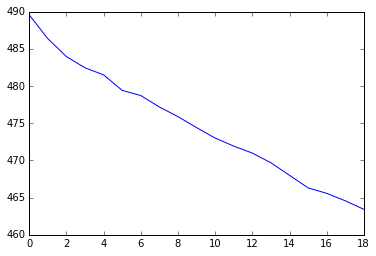

In [156]:
plt.plot(inertia_k)

In [157]:
num_clusters = 18

km = MiniBatchKMeans(n_clusters = num_clusters)
km.fit(tas_rev)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=18,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [158]:
clusters = km.labels_.tolist()

In [165]:
tas = [str(rev) for rev in tas_df.review[:500]]

In [166]:
tas_rev_df = pd.DataFrame(tas, index=clusters, columns=['Tasting Reviews'])

In [168]:
for cluster_num in range(num_clusters):
    print 'Cluster {0}'.format(cluster_num + 1)
    for review in tas_rev_df[tas_rev_df.index == cluster_num].values:
        print review
    print

Cluster 1
[ 'Dark garnet black color. Mellow aromas of sour cherry, mulberry, and hint of smoked fish with a supple, dry-yet-fruity medium body and a tingling, breezy, vanilla, nut, and pear finish with medium tannins and light oak. A nice easy drinking red for the table.']
[ 'Earthy black raspberry, crushed cherry, wild mushrooms, dried boysenberry, damson plums and Autumn leaves funk lead to a silky, sexy palate and if not long, perfectly balanced finish. Sure to turn a new world Pinot lover into an old world pinot lover.']
[ 'Garnet black color. Aromas of chocolate, sandalwood, and spicy cranberry chutney with a silky, dry-yet-fruity medium body and a juicy dark cherry, tomato, white nut, and mineral driven finish. Elegant and stylish.']
[ 'Garnet black color. Aromas of chocolate raisins, pepper, and lit candle with a supple, dry-yet-fruity medium body and a tart, tannic pomegranate, apple core and mineral finish.']
[ 'Opaque garnet black color. Resonant aromas of currant jam and ho

### Snooth Wine

In [3]:
snooth = eat_pickles('wine_dict_fresh_2.pkl')

In [4]:
snooth_df = pd.DataFrame(snooth)

In [5]:
len(snooth_df)

3889

#### Locate non-wines and drop them from the dataframe

In [6]:
non_wine = ['Vodka', 'Vermouth', 'Whiskey', 'Rum', 'Sangria', 'Tequila', 'Liqueur', 'Brandy', 'Scotch', \
        'Single Malt Scotch', 'Scotch Single Malt', 'Bourbon', 'Whiskey Rye', 'Burgundy', 'Irish Whiskey', \
        'Cream Liqueur', 'Spirit' 'Gin', 'Cognac; Armagnac', 'Liqueurs', 'Apertif And Bitters', 'Whiskey Bourbon', \
        'Cognac', 'Whisky', 'Accessories']

indices_to_drop = []

for index, winename in enumerate(snooth_df['name']):
    for nonwine in non_wine:
        if nonwine in winename:
            indices_to_drop.append(index)

In [7]:
indices_to_drop = list(indices_to_drop)

In [8]:
indices_to_add = [60, 514, 2659, 2785, 3211, 3297]
indices_to_drop = indices_to_drop + indices_to_add

In [9]:
print indices_to_drop

[122, 157, 202, 202, 239, 285, 291, 322, 384, 413, 430, 441, 444, 444, 454, 572, 614, 651, 679, 712, 720, 740, 740, 777, 897, 919, 937, 954, 965, 1064, 1064, 1065, 1106, 1158, 1284, 1286, 1359, 1402, 1456, 1458, 1516, 1540, 1624, 1665, 1772, 1869, 1908, 1926, 1984, 1984, 2107, 2124, 2173, 2208, 2240, 2356, 2423, 2435, 2496, 2508, 2540, 2561, 2623, 2627, 2643, 2646, 2653, 2716, 2762, 2800, 2895, 2899, 2899, 3051, 3076, 3084, 3166, 3197, 3229, 3250, 3323, 3363, 3378, 3383, 3430, 3485, 3489, 3498, 3508, 3520, 3594, 3604, 3650, 3657, 3666, 3679, 3688, 3820, 3878, 60, 514, 2659, 2785, 3211, 3297]


In [10]:
snooth_df = snooth_df.drop(snooth_df.index[[indices_to_drop]])

In [13]:
snooth_df.head()

,color,name,notes,region,reviews,varietal
0,White,Donnafugata Ben Rye 2012,92 points Wine Spectator: A rich and mouthwate...,Italy,[Looking for a sophisticated and refined sweet...,Muscat
1,Red,Jade Mountain Merlot 2012,Jade Mountain showcases the art of blending. W...,USA,[Jade Mountain showcases the art of blending. ...,Merlot
2,Red,W Allegrini Valpol Classico 2008,"A well-structured, complex, elegant and velvet...",Italy,"[Ripe, sweet fruit flavors of damson plum and ...",Valpolicella
3,White,Castello di Pomino Benefizio DOC 2008,The Castello di Pomino was built in the 16th c...,Italy,[One of the major and largest vine growing bus...,Chardonnay
4,Red,Ridge Vineyards Three Valleys Zinfandel 2012,While their Cabernet-based bottling of Monte B...,USA,[Four glasses],Zinfandel


In [227]:
# Count how many reviews are empty
count = 0
for review in snooth_df.reviews:
    if len(review) == 0:
        count += 1

In [228]:
# Total number of wines that have reviews in the data set
print len(snooth_df) - count

3125


In [229]:
# Change some mistakes that were made when categorizing
snooth_df['varietal'][1133] = 'Other White Wine'
snooth_df['varietal'][2616] = 'Other White Wine'
snooth_df['varietal'][1733] = 'Other Red Wine'
snooth_df['varietal'][1690] = 'Chardonnay'
snooth_df['varietal'][535] = 'Non-Vintage Sparkling Wine'
snooth_df['varietal'][2547] = 'Bordeaux Red Blends'
snooth_df['varietal'][3014] = 'Non-Vintage Sparkling Wine'
snooth_df['varietal'][1890] = 'Gruner Veltliner'

In [230]:
snooth_df.varietal.value_counts()

Chardonnay                    481
Cabernet Sauvignon            413
Pinot Noir                    339
Syrah                         184
Other Red Blends              171
Sauvignon Blanc               145
Merlot                        136
Sangiovese                    126
Riesling                       99
Zinfandel                      98
Nebbiolo                       84
Malbec                         71
Pinot Grigio                   70
Other White Blends             70
Muscat                         65
Other White Wine               59
Other Red Wine                 55
Grenache                       50
Tempranillo                    50
Rhone Red Blends               44
Non-Vintage Sparkling Wine     44
Bordeaux Red Blends            37
Research                       34
Sherry                         26
Valpolicella                   23
Barbera                        21
Cabernet Franc                 19
Chenin Blanc                   16
Mourvedre                      14
Pinot Blanc   

#### TF-IDF on notes

In [375]:
notes_corpus = list(snooth_df['notes'][:500].values)

In [354]:
additional = ['cabernet', 'sauvignon', 'syrah', 'sirah', 'merlot', 'wine', 'pinot', 'chardonnay', 'malbec']

In [359]:
stop_words = text.ENGLISH_STOP_WORDS.union(additional)

In [376]:
vectorizer = TfidfVectorizer(min_df=1, stop_words=stop_words, ngram_range=(1,3))
notes = vectorizer.fit_transform(notes_corpus)
idf = vectorizer.idf_
notes = notes.toarray()

In [377]:
notes.shape

(500, 42347)

In [366]:
for i, note in enumerate(notes):
    tf_idf = dict([(word, count) for (word, count) in zip(vectorizer.get_feature_names(), note) if count > 0])
    print
    print 'Top 10 TF-IDF Words for Document: {0}'.format(i+1)
    for common in collections.Counter(tf_idf).most_common(10):
        print common


Top 10 TF-IDF Words for Document: 1
(u'grapes zibibbo', 0.10475730242258049)
(u'expressive baked peach', 0.10475730242258049)
(u'moscato alessandria alcohol', 0.10475730242258049)
(u'cases imported 28', 0.10475730242258049)
(u'green tea', 0.10475730242258049)
(u'real drive fruit', 0.10475730242258049)
(u'flavors real', 0.10475730242258049)
(u'expressive baked', 0.10475730242258049)
(u'notes ring long', 0.10475730242258049)
(u'ring', 0.10475730242258049)

Top 10 TF-IDF Words for Document: 2
(u'multiple', 0.1257127123721932)
(u'showcases', 0.11492677975213306)
(u'appellation', 0.096723398977667616)
(u'county', 0.095681317217025122)
(u'flavors caramel oak', 0.069536152348465538)
(u'quality appellation tier', 0.069536152348465538)
(u'showcases art', 0.069536152348465538)
(u'exceptional quality appellation', 0.069536152348465538)
(u'aromas open nose', 0.069536152348465538)
(u'value primarily featured', 0.069536152348465538)

Top 10 TF-IDF Words for Document: 3
(u'colour warm spicy', 0.1989

KeyboardInterrupt: 

In [391]:
print "%d documents" % len(notes)
print

print "Extracting features from the training dataset using a sparse vectorizer"
t0 = time()

print "done in %fs" % (time() - t0)
print "n_samples: %d, n_features: %d" % notes.shape
print


###############################################################################
# Do the actual clustering

mini_km = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=1,
                         init_size=1000,
                         batch_size=1000, verbose=1)

km = KMeans(n_clusters=2, init='random', max_iter=100, n_init=1, verbose=1)

print "Clustering sparse data with %s" % km
t0 = time()
km.fit(notes)
print "done in %0.3fs" % (time() - t0)
print

#print "Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_)
#print "Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_)
#print "V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_)
#print "Adjusted Rand-Index: %.3f" % \
#    metrics.adjusted_rand_score(labels, km.labels_)
#print "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(
#    X, labels, sample_size=1000)

#print

500 documents

Extracting features from the training dataset using a sparse vectorizer
done in 0.000040s
n_samples: 500, n_features: 42347

Clustering sparse data with KMeans(copy_x=True, init=u'random', max_iter=100, n_clusters=2, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=1)
Initialization complete
Iteration  0, inertia 984.068
Iteration  1, inertia 494.020
Iteration  2, inertia 494.012
Converged at iteration 2
done in 0.848s



In [392]:
km.labels_

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0,

In [393]:
snooth_df.head(20)

,color,name,notes,region,reviews,varietal
0,White,Donnafugata Ben Rye 2012,92 points Wine Spectator: A rich and mouthwate...,Italy,[Looking for a sophisticated and refined sweet...,Muscat
1,Red,Jade Mountain Merlot 2012,Jade Mountain showcases the art of blending. W...,USA,[Jade Mountain showcases the art of blending. ...,Merlot
2,Red,W Allegrini Valpol Classico 2008,"A well-structured, complex, elegant and velvet...",Italy,"[Ripe, sweet fruit flavors of damson plum and ...",Valpolicella
3,White,Castello di Pomino Benefizio DOC 2008,The Castello di Pomino was built in the 16th c...,Italy,[One of the major and largest vine growing bus...,Chardonnay
4,Red,Ridge Vineyards Three Valleys Zinfandel 2012,While their Cabernet-based bottling of Monte B...,USA,[Four glasses],Zinfandel
5,White,Canyon Road Chardonnay 2013,"Eine exzellente Aromatik - sehr intensiv, komp...",USA,[],Chardonnay
6,Red,Stag's Leap Wine Cellars Hands of Time 2013,"Stag's Leap Wine Cellars ""Hands of Time"" Chard...",USA,[This Napa Valley red blend offers aromas of m...,Chardonnay
7,Red,Blackburn Wine Company Cabernet Sauvignon Paso...,Our intention with Blackburn Wines is to creat...,USA,"[This wine is from United States, California r...",Cabernet Sauvignon
8,Red,Wolf Blass Cabernet Sauvignon Langhorne Creek ...,"Rubinrote Farbe, Aromen, die an frische, rote ...",Australia,"[Dark and juicy, this is focused on its lovely...",Cabernet Sauvignon
9,White,Decopas Sauvignon Blanc 2013,"100% Sauvignon Blanc from Mendoza, Argentina. ...",Argentina,[],Sauvignon Blanc


In [389]:
notes_corpus[1]

u'Jade Mountain showcases the art of blending. Winemaker Domenica Totty carefully blends together multiple wine varieties or appellations to create wines of great flavor and exceptional quality. Our Appellation Tier showcases multi-appellation Cabernet Sauvignon, Merlot and Chardonnay of remarkable value. Primarily featured off-premise, these wines bring out the best in a wide variety of dishes. \n\n Wine: \nRich chocolate and black raspberry aromas open the nose of our 2011 Merlot. With fruit from Napa County, Monterey County and San Luis Obispo, the wine offers multiple layers of flavors. Caramel oak and smoky vanilla notes weave through the fruit-driven palate that is dominated by red cherry, brambly berries and ripe plums. The bright entry evolves with firm tannins and a lush finish. Pair this well-balanced Merlot with pasta, game or assorted cheeses. - Winery'

In [390]:
notes_corpus[2]

u'A well-structured, complex, elegant and velvety wine, with intense ruby red colour. It has a warm and spicy bouquet, with aroma of raisins.'

In [ ]:
#for review in snooth_df[snooth_df.color == 'Red']['notes'][:100]:
#    red_notes_corpus.append(str(' '.join(review.encode('ascii', 'ignore').split())))